# Import

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

# Load data

In [4]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv"
df = pd.read_csv(url)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Explore data 

In [5]:
def summarize_df(df_):
    df = df_.copy()
    report = pd.DataFrame({
                        'dtype':df.dtypes,
                        '# null': df.isna().sum(),
                        'null (%)': df.isna().sum()/len(df)*100,
                        'nunique':df.nunique(),
                        "min":df.min(),
                        'max':df.max()
             })
    report.index.name='Column'
    return report.reset_index()
summarize_df(df)

,Column,dtype,# null,null (%),nunique,min,max
0,symboling,int64,0,0.0,6,-2,3
1,fueltype,object,0,0.0,2,diesel,gas
2,aspiration,object,0,0.0,2,std,turbo
3,doornumber,object,0,0.0,2,four,two
4,carbody,object,0,0.0,5,convertible,wagon
5,drivewheel,object,0,0.0,3,4wd,rwd
6,enginelocation,object,0,0.0,2,front,rear
7,wheelbase,float64,0,0.0,53,86.6,120.9
8,carlength,float64,0,0.0,75,141.1,208.1
9,carwidth,float64,0,0.0,44,60.3,72.3


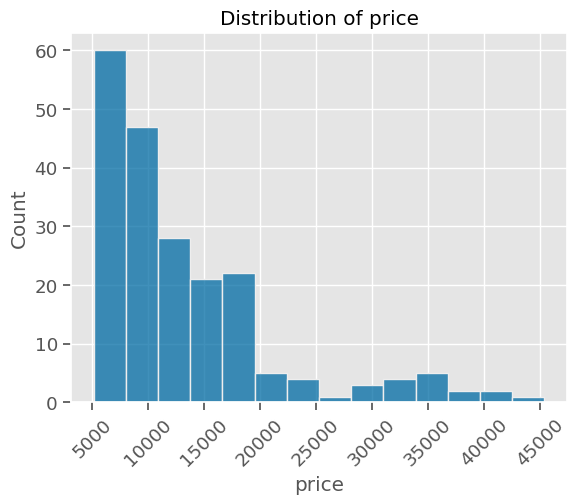

In [10]:
## plot price 
plt.style.use(('ggplot','tableau-colorblind10'))
sns.set_context(context='notebook', font_scale= 1.2)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.facecolor']='white'
ax = sns.histplot(data=df,x='price');
ax.set_title("Distribution of price")
plt.xticks(rotation = 45)
plt.show()

No missing values, next step make column selector and use ohe. 
Do not need Scale. 

# Preprocessing

## Train Test Split

In [11]:
## Make x and y variables
y = df['price'].copy()
X = df.drop(columns=['price']).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
17,0,gas,std,four,sedan,rwd,front,110.0,197.0,70.9,56.3,3505,ohc,6,209,mpfi,3.62,3.39,8.0,182,5400,15,20
39,0,gas,std,four,sedan,fwd,front,96.5,175.4,65.2,54.1,2304,ohc,4,110,1bbl,3.15,3.58,9.0,86,5800,27,33
40,0,gas,std,four,sedan,fwd,front,96.5,175.4,62.5,54.1,2372,ohc,4,110,1bbl,3.15,3.58,9.0,86,5800,27,33
47,0,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,52.8,4066,dohc,6,258,mpfi,3.63,4.17,8.1,176,4750,15,19
123,-1,gas,std,four,wagon,fwd,front,103.3,174.6,64.6,59.8,2535,ohc,4,122,2bbl,3.35,3.46,8.5,88,5000,24,30


## Make a column selector

In [12]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'fuelsystem']

In [13]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'cylindernumber',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg']

## Make a column transform

In [14]:
#Create a OneHotEncoder for one-hot encoding the categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_tuple = (ohe, cat_sel)

In [18]:
preprocessor = make_column_transformer(cat_tuple, remainder = 'passthrough', verbose_feature_names_out=False)
preprocessor 

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001E4A5B8BDC0>)],
                  verbose_feature_names_out=False)

In [ ]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)

## Get feature names

In [20]:
## run get_feature_names_out
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'fuelsystem_1bbl', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi',
       'symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg'], dtype=object)

## Create a preprocessed DataFrame for our training  and test set.

In [21]:
# train set 
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
17,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,110.0,197.0,70.9,56.3,3505.0,6.0,209.0,3.62,3.39,8.0,182.0,5400.0,15.0,20.0
39,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.5,175.4,65.2,54.1,2304.0,4.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0
40,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.5,175.4,62.5,54.1,2372.0,4.0,110.0,3.15,3.58,9.0,86.0,5800.0,27.0,33.0


In [22]:
# test set 
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
48,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,113.0,199.6,69.6,52.8,4066.0,6.0,258.0,3.63,4.17,8.1,176.0,4750.0,15.0,19.0
196,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.0,104.3,188.8,67.2,56.2,2935.0,4.0,141.0,3.78,3.15,9.5,114.0,5400.0,24.0,28.0
148,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.9,173.6,65.4,54.9,2420.0,4.0,108.0,3.62,2.64,9.0,82.0,4800.0,23.0,29.0


# RandomForestRegressor model 

## Create a function to evaluate the model 

In [23]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [24]:
# create a model 
reg = RandomForestRegressor(random_state=SEED)
# fit the model 
reg.fit(X_train_df,y_train)
# evaluate the model 
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.99	RMSE= 860.80
Test Data:	R^2= 0.93	RMSE= 2286.81


# Extract and Plot the Feature Importances calculated by your model

In [26]:
reg.feature_importances_

array([7.46198406e-05, 1.59585590e-04, 1.03532933e-03, 8.98888139e-04,
       3.24265478e-04, 4.25621828e-04, 1.63762000e-04, 4.23666869e-04,
       3.41484870e-04, 1.34377499e-03, 1.18452178e-04, 5.88510598e-05,
       1.41352374e-03, 5.67150223e-04, 0.00000000e+00, 2.64150873e-04,
       1.90083003e-05, 3.50365775e-05, 1.10097440e-03, 3.67979821e-05,
       5.54954582e-04, 2.36907019e-05, 1.27894699e-05, 1.31677206e-04,
       3.92853530e-05, 3.59998179e-04, 9.00381584e-06, 8.78626711e-04,
       2.21467521e-05, 1.43261911e-05, 2.54925631e-03, 3.61802162e-02,
       6.92711850e-03, 4.43546666e-02, 3.72186522e-03, 2.30432821e-01,
       1.40116016e-03, 5.25463893e-01, 4.16799625e-03, 7.03324496e-03,
       1.47562208e-02, 2.17065371e-02, 5.14201654e-03, 1.21059077e-02,
       7.32056362e-02])

In [27]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

45
45


True

In [28]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

fueltype_diesel         0.000075
fueltype_gas            0.000160
aspiration_std          0.001035
aspiration_turbo        0.000899
doornumber_four         0.000324
doornumber_two          0.000426
carbody_convertible     0.000164
carbody_hardtop         0.000424
carbody_hatchback       0.000341
carbody_sedan           0.001344
carbody_wagon           0.000118
drivewheel_4wd          0.000059
drivewheel_fwd          0.001414
drivewheel_rwd          0.000567
enginelocation_front    0.000000
enginetype_dohc         0.000264
enginetype_dohcv        0.000019
enginetype_l            0.000035
enginetype_ohc          0.001101
enginetype_ohcf         0.000037
enginetype_ohcv         0.000555
enginetype_rotor        0.000024
fuelsystem_1bbl         0.000013
fuelsystem_2bbl         0.000132
fuelsystem_4bbl         0.000039
fuelsystem_idi          0.000360
fuelsystem_mfi          0.000009
fuelsystem_mpfi         0.000879
fuelsystem_spdi         0.000022
fuelsystem_spfi         0.000014
symboling 

In [29]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=True)
sorted_importance

enginelocation_front    0.000000
fuelsystem_mfi          0.000009
fuelsystem_1bbl         0.000013
fuelsystem_spfi         0.000014
enginetype_dohcv        0.000019
fuelsystem_spdi         0.000022
enginetype_rotor        0.000024
enginetype_l            0.000035
enginetype_ohcf         0.000037
fuelsystem_4bbl         0.000039
drivewheel_4wd          0.000059
fueltype_diesel         0.000075
carbody_wagon           0.000118
fuelsystem_2bbl         0.000132
fueltype_gas            0.000160
carbody_convertible     0.000164
enginetype_dohc         0.000264
doornumber_four         0.000324
carbody_hatchback       0.000341
fuelsystem_idi          0.000360
carbody_hardtop         0.000424
doornumber_two          0.000426
enginetype_ohcv         0.000555
drivewheel_rwd          0.000567
fuelsystem_mpfi         0.000879
aspiration_turbo        0.000899
aspiration_std          0.001035
enginetype_ohc          0.001101
carbody_sedan           0.001344
cylindernumber          0.001401
drivewheel

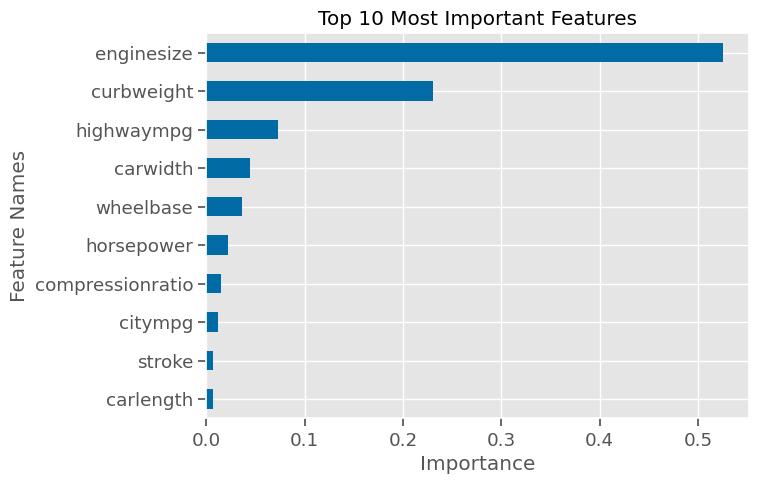

In [30]:
## plotting top 10 importances
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

## What were your 5 most important features?

The top 5 most important features are:

enginesize

curbweight

highwaympg

carwidth

wheelbase


## What does it mean that they were "important"?

An "important' feature is one that was used extensively/repeatedly by the model when during the training process. Feature Importance does not indicate directionality.

# Apply sklearn's permutation importance and visualize the permutation importances.

In [31]:
from sklearn.inspection import permutation_importance
## Permutation importance takes a fit model and the test data.
r = permutation_importance(reg, X_train_df, y_train ,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [35]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
perm_importances

fueltype_diesel        -3.964134e-06
fueltype_gas           -1.702364e-05
aspiration_std          2.074835e-04
aspiration_turbo        2.844710e-04
doornumber_four         3.630207e-04
doornumber_two          6.433263e-04
carbody_convertible     9.045981e-05
carbody_hardtop         3.366123e-04
carbody_hatchback       2.758891e-04
carbody_sedan           1.063629e-03
carbody_wagon           2.138996e-04
drivewheel_4wd          1.505614e-05
drivewheel_fwd          1.025808e-03
drivewheel_rwd          4.005293e-04
enginelocation_front    0.000000e+00
enginetype_dohc         1.125962e-04
enginetype_dohcv        1.141886e-06
enginetype_l            3.826450e-06
enginetype_ohc          6.530808e-04
enginetype_ohcf         1.739617e-05
enginetype_ohcv         1.963090e-04
enginetype_rotor        1.247674e-06
fuelsystem_1bbl         5.379142e-06
fuelsystem_2bbl         1.118315e-04
fuelsystem_4bbl         1.909982e-05
fuelsystem_idi          3.304714e-05
fuelsystem_mfi          4.357507e-07
f

In [36]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_perm_importances = perm_importances.sort_values(ascending=True)
sorted_perm_importances

fueltype_gas           -1.702364e-05
fueltype_diesel        -3.964134e-06
fuelsystem_spfi        -2.461533e-07
enginelocation_front    0.000000e+00
fuelsystem_mfi          4.357507e-07
enginetype_dohcv        1.141886e-06
enginetype_rotor        1.247674e-06
enginetype_l            3.826450e-06
fuelsystem_1bbl         5.379142e-06
fuelsystem_spdi         6.270593e-06
drivewheel_4wd          1.505614e-05
enginetype_ohcf         1.739617e-05
fuelsystem_4bbl         1.909982e-05
fuelsystem_idi          3.304714e-05
carbody_convertible     9.045981e-05
fuelsystem_2bbl         1.118315e-04
enginetype_dohc         1.125962e-04
enginetype_ohcv         1.963090e-04
aspiration_std          2.074835e-04
carbody_wagon           2.138996e-04
carbody_hatchback       2.758891e-04
aspiration_turbo        2.844710e-04
carbody_hardtop         3.366123e-04
doornumber_four         3.630207e-04
drivewheel_rwd          4.005293e-04
fuelsystem_mpfi         5.120655e-04
doornumber_two          6.433263e-04
e

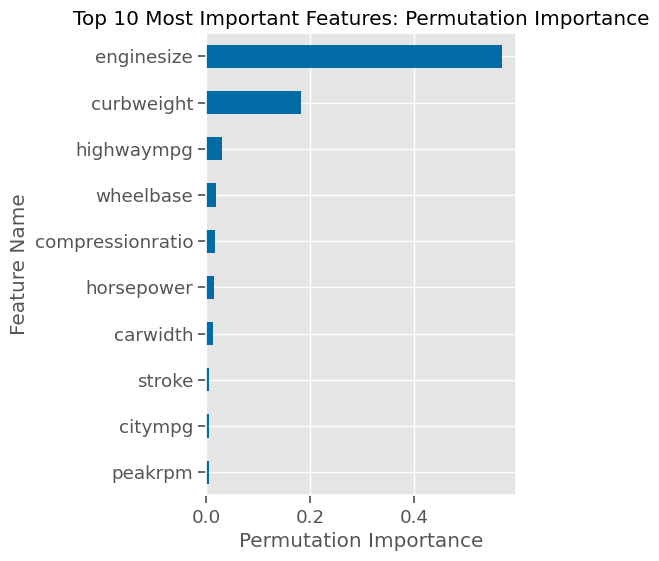

In [33]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

##  What were your 5 most important features?

The top 5 most important features are:

enginesize

curbweight

highwaympg

wheelbase

compressionratio        


## Are they the same features that your model has as the top 5 important?

No, enginesize, curbweeight, highwaympg, and wheelbase appear in both, but in compressionratio only in permutation importance and carwidth in Feature Importances